## Reading the data, and normalizing the data

In [198]:
import csv
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

features = ["file_size(KB)","record_size(KB)","num_threads","memory_size"]
label = "throughput(KB/ms)"

df = pd.read_csv("delta_results.csv")

X = df[features]
y = df[label]
y = y / 1000 # KB/s

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Spliting the data into training and testing datasets 

In [199]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

## Fitting a Linear Regression model

In [200]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

LinearRegression()

## Fitting a Gamma GLM Regressor

In [201]:
from sklearn.linear_model import GammaRegressor

glm_model = GammaRegressor()

glm_model.fit(X_train, y_train)

GammaRegressor()

## Fitting a Gaussian Process Regressor

In [202]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp_model = GaussianProcessRegressor()

gp_model.fit(X_train, y_train)

GaussianProcessRegressor()

## Fitting a Multi-layer Perceptron Regressor (Neural Network)

In [203]:
from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor(max_iter=1000)

mlp_model.fit(X_train, y_train)

MLPRegressor(max_iter=1000)

## Evaluating Models

In [204]:
predictions = {
    "LinearRegression": lr_model.predict(X_test),
    "GammaRegressor": glm_model.predict(X_test),
    "GaussianProcessRegressor": gp_model.predict(X_test),
    "MLPRegressor": mlp_model.predict(X_test),
}

In [205]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error # type: ignore

data = {}

for model, y_pred in predictions.items():
    RMSE = root_mean_squared_error(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    data[model] = [RMSE, MAE]

rdf = pd.DataFrame(data=data, index=['RMSE', 'MAE'])
rdf

,LinearRegression,GammaRegressor,GaussianProcessRegressor,MLPRegressor
RMSE,2.936494,2.953998,3.102494,2.882950
MAE,2.651550,2.662781,2.793076,2.652499


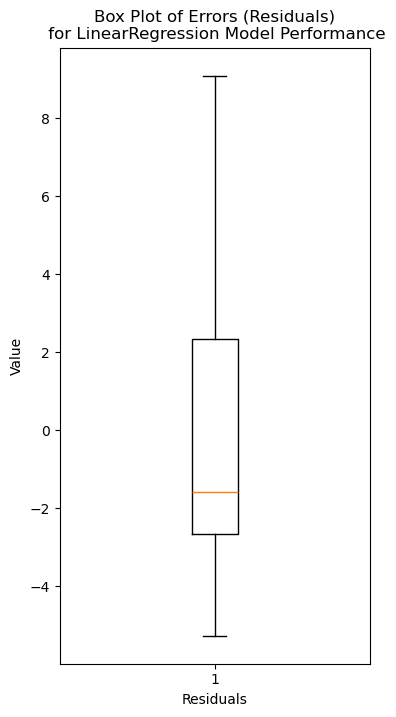

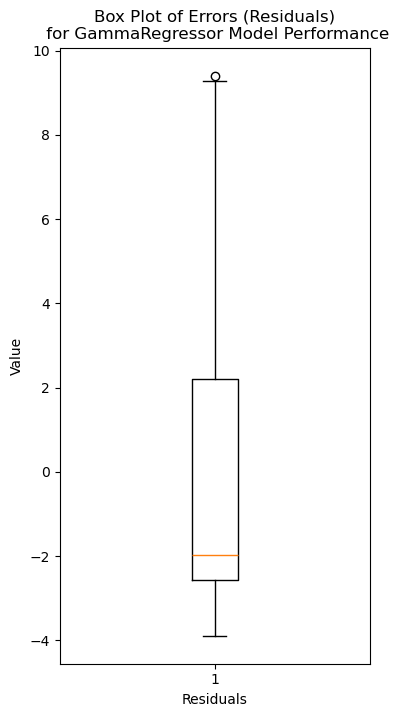

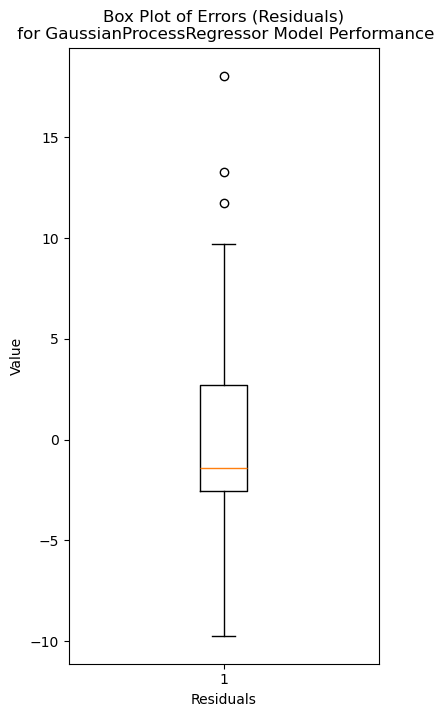

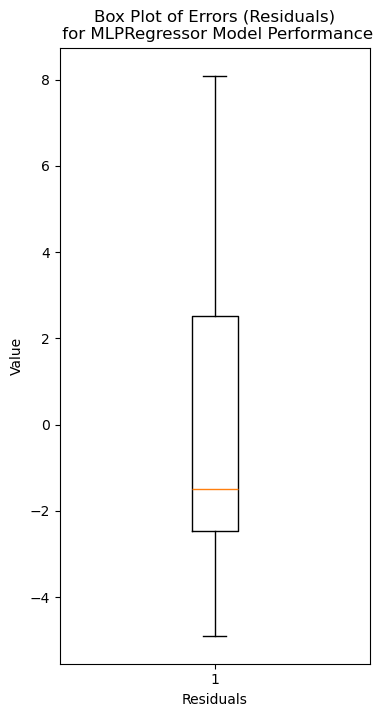

In [206]:
import matplotlib.pyplot as plt

for model, y_pred in predictions.items():
    residuals = y_test - y_pred
    plt.figure(figsize=(4, 8))  # Adjust figure size as needed
    plt.boxplot(residuals)
    
    plt.xlabel("Residuals")
    plt.ylabel("Value")
    plt.title(f"Box Plot of Errors (Residuals)\n for {model} Model Performance")
    plt.show()

In [207]:
grouped = df.groupby(features)[label].var()
grouped.to_csv("delta_results_variance.csv")

df_v = pd.read_csv("delta_results_variance.csv")

X = df_v[features]
y = df_v[label]

y = y / 1000 # KB/s

vscaler = StandardScaler()

X_scaled = vscaler.fit_transform(X)


In [208]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

In [209]:
from sklearn.linear_model import LinearRegression

lr_vmodel = LinearRegression()

lr_vmodel.fit(X_train, y_train)

LinearRegression()

In [210]:
from sklearn.linear_model import GammaRegressor

glm_vmodel = GammaRegressor()

glm_vmodel.fit(X_train, y_train)

GammaRegressor()

In [211]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp_vmodel = GaussianProcessRegressor()

gp_vmodel.fit(X_train, y_train)

GaussianProcessRegressor()

In [212]:
from sklearn.neural_network import MLPRegressor

mlp_vmodel = MLPRegressor(max_iter=1000)

mlp_vmodel.fit(X_train, y_train)

c:\Users\Arkva\scoop\apps\miniconda3\current\envs\final\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(max_iter=1000)

In [213]:
vpredictions = {
    "LinearRegression": lr_vmodel.predict(X_test),
    "GammaRegressor": glm_vmodel.predict(X_test),
    "GaussianProcessRegressor": gp_vmodel.predict(X_test),
    "MLPRegressor": mlp_vmodel.predict(X_test),
}

In [214]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error # type: ignore

data = {}



for model, y_pred in vpredictions.items():
    RMSE = root_mean_squared_error(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    data[model] = [RMSE, MAE]

rdf = pd.DataFrame(data=data, index=['RMSE', 'MAE'])
rdf

,LinearRegression,GammaRegressor,GaussianProcessRegressor,MLPRegressor
RMSE,5279.032179,6706.38697,9.027689e+06,12706.243010
MAE,3454.896319,4388.09442,1.263372e+06,9091.137863


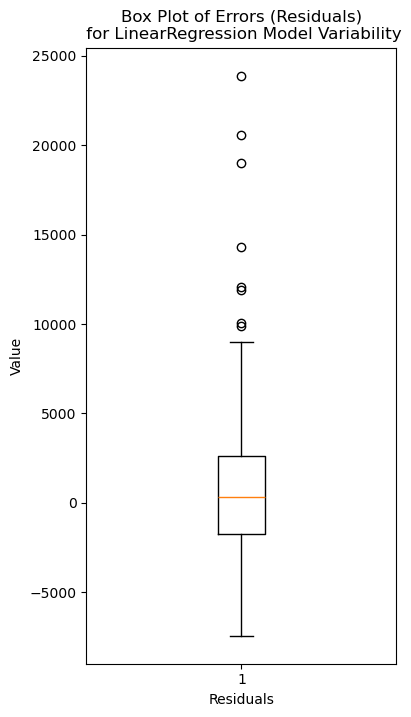

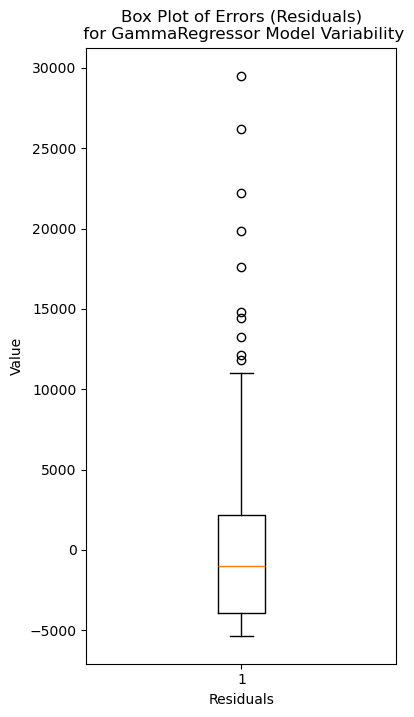

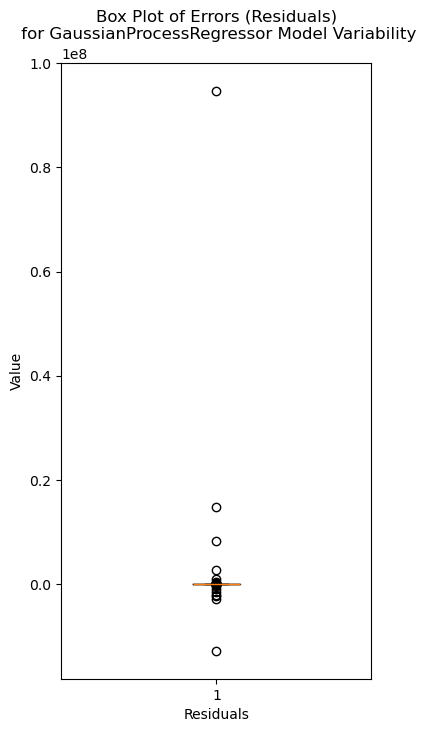

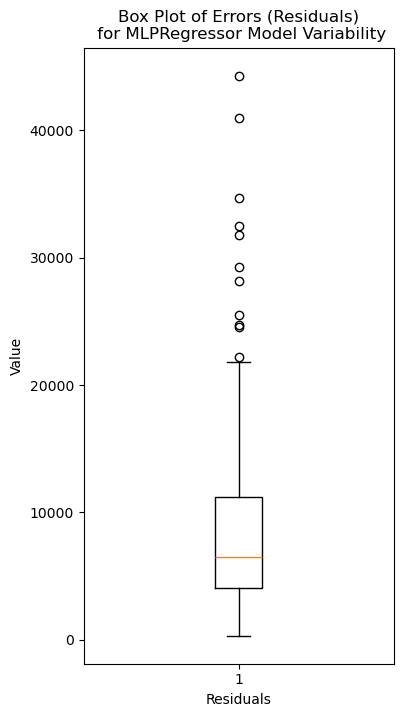

In [215]:
import matplotlib.pyplot as plt

for model, y_pred in vpredictions.items():
    
    residuals = y_test - y_pred
    plt.figure(figsize=(4, 8))  # Adjust figure size as needed
    plt.boxplot(residuals)
    
    plt.xlabel("Residuals")
    plt.ylabel("Value")
    plt.title(f"Box Plot of Errors (Residuals)\n for {model} Model Variability")
    plt.show()

In [224]:
from scipy.optimize import direct, Bounds
import warnings

warnings.filterwarnings("ignore")

models = [
    [lr_model, lr_vmodel],
    [glm_model, glm_vmodel],
    [gp_model, gp_vmodel],
    [mlp_model, mlp_vmodel],
]

for model_pair in models:
    mx = model_pair[0]
    fx = model_pair[1]
    m0 = df_v["throughput(KB/ms)"].min()
    c = 1000
    u = 1

    def objective(x):
        x = [x]
        xp = scaler.transform(X=x)
        xv = vscaler.transform(X=x) # type: ignore
        return (
            fx.predict(xv)
            + (1 / 2 * c) * max(0, u + c * (m0 - mx.predict(xp))) ** 2
            - u**2
        )

    bounds = Bounds([64, 32, 1, 1], [1024, 512, 128, 128])  # type: ignore

    result = direct(objective, bounds)  # type: ignore
    print(result.x, result.nfev)
    print("---- Optimal values -----")
    print("File Size:  ", result.x[0])
    print("Record Size:", result.x[1])
    print("Num Threads:", result.x[2])
    print("Memory Size:", result.x[3])

[970.66666667 485.33333333   8.05555556   8.05555556] 2977
---- Optimal values -----
File Size:   970.6666666666666
Record Size: 485.3333333333333
Num Threads: 8.055555555555559
Memory Size: 8.055555555555559
[970.66666667 485.33333333   8.05555556   8.05555556] 2985
---- Optimal values -----
File Size:   970.6666666666666
Record Size: 485.3333333333333
Num Threads: 8.055555555555559
Memory Size: 8.055555555555559
[1022.75628715   80.10242341  127.9903216   104.25887822] 4005
---- Optimal values -----
File Size:   1022.7562871513487
Record Size: 80.1024234110654
Num Threads: 127.99032159731748
Memory Size: 104.25887821978357
[970.66666667 485.33333333 120.94444444 120.94444444] 2991
---- Optimal values -----
File Size:   970.6666666666666
Record Size: 485.3333333333333
Num Threads: 120.94444444444444
Memory Size: 120.94444444444444
